In [16]:
import joblib
# Train and compare: LinearRegression, RandomForest, XGBoost, and SVR
# One shared preprocessing pipeline: StandardScaler (numeric) + OneHotEncoder (categorical)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor





# 1) Load data
csv_path = "ensurance.csv"  # <-- change if needed
df = pd.read_csv(csv_path)

# 2) Split into X (features) and y (target)
y = df["charges"]
X = df.drop(columns=["charges"])



# 3) Define numeric and categorical columns
numeric_cols = [c for c in ["age", "bmi", "children"] if c in X.columns]
categorical_cols = [c for c in ["sex", "smoker", "region"] if c in X.columns]
df['charges']=np.log1p(df['charges'])

# Helper: build a fresh preprocessor each time
def make_preprocessor():

    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(drop="first"), categorical_cols),
        ],

    )


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "SVR_RBF": SVR(),  # scaling in the pipeline helps SVR
}

models["XGBRegressor"] = XGBRegressor(

        random_state=42,

    )

def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2




rows = []
for name, model in models.items():
    preprocessor = make_preprocessor()
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse, mae, r2 = eval_metrics(y_test, y_pred)
    rows.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2})
    print(f"{name:22s} -> RMSE:{rmse:8.2f}  MAE:{mae:8.2f}  R²:{r2:7.4f}")


print("\nSummary (lower RMSE/MAE is better, higher R² is better):")
results_before = pd.DataFrame(rows)
print(results_before)

LinearRegression       -> RMSE: 5796.28  MAE: 4181.19  R²: 0.7836
RandomForestRegressor  -> RMSE: 4567.78  MAE: 2543.98  R²: 0.8656
SVR_RBF                -> RMSE:12897.60  MAE: 8606.59  R²:-0.0715
XGBRegressor           -> RMSE: 4840.94  MAE: 2765.75  R²: 0.8491

Summary (lower RMSE/MAE is better, higher R² is better):
                   Model          RMSE          MAE        R2
0       LinearRegression   5796.284659  4181.194474  0.783593
1  RandomForestRegressor   4567.775116  2543.975825  0.865606
2                SVR_RBF  12897.600111  8606.592261 -0.071494
3           XGBRegressor   4840.940468  2765.746813  0.849051


story 3 :evaluer

RANDOMFOREST(grid search)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np



rf_pipe = Pipeline([
    ("preprocess", make_preprocessor()),
    ("model", RandomForestRegressor(random_state=42)),
])

# Small, focused grid (24 combos)
rf_grid = {
    "model__n_estimators": [400, 800],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],


}

rf_search = GridSearchCV(
    rf_pipe,
    param_grid=rf_grid,

    cv=5,

)
rf_search.fit(X_train, y_train)

print("RandomForest (GridSearch)")
print("Best params:", rf_search.best_params_)


ERROR! Session/line number was not unique in database. History logging moved to new session 41
RandomForest (GridSearch)
Best params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 400}


In [32]:
#backup

rf_pipe = Pipeline([
    ("preprocess", make_preprocessor()),
    ("model", RandomForestRegressor(random_state=42 , max_depth = 10, min_samples_split= 5,n_estimators=400))
])
rf_search.fit(X_train, y_train)

rf_best = rf_search.best_estimator_
y_pred_rf = rf_best.predict(X_test)

rmse_rf = float(np.sqrt(mean_squared_error(y_test, y_pred_rf)))
mae_rf = float(mean_absolute_error(y_test, y_pred_rf))
r2_rf = float(r2_score(y_test, y_pred_rf))



print(f"Test R²: {r2_rf:.4f} | RMSE: {rmse_rf:.2f} | MAE: {mae_rf:.2f} ")

rndf = [rmse_rf, mae_rf, r2_rf]

Test R²: 0.8692 | RMSE: 4505.75 | MAE: 2525.22 


XGBRegressor (GridSearchCV, small grid)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np



xgb_pipe = Pipeline([
    ("preprocess", make_preprocessor()),
    ("model", XGBRegressor(

        random_state=42,



    )),
])

# Small, balanced grid (32 combos)
xgb_grid = {

    "model__max_depth": [3, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.8, 1.0],

}

xgb_search = GridSearchCV(
    xgb_pipe,
    param_grid=xgb_grid,
    scoring="neg_mean_squared_error",
    cv=5,


)
xgb_search.fit(X_train, y_train)



print("XGBoost (GridSearch)")
print("Best params:", xgb_search.best_params_)


XGBoost (GridSearch)
Best params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__subsample': 0.8}


enregistrer et rentrainait

In [22]:

xgb_pipe = Pipeline([
    ("preprocess", make_preprocessor()),
    ("model", XGBRegressor(

        random_state=42,learning_rate= 0.05, max_depth=3, subsample= 0.8



    )),
])

xgb_search.fit(X_train, y_train)

xgb_best = xgb_search.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)

rmse_xgb = float(np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
mae_xgb = float(mean_absolute_error(y_test, y_pred_xgb))
r2_xgb = float(r2_score(y_test, y_pred_xgb))



print(f"Test R²: {r2_xgb:.4f} | RMSE: {rmse_xgb:.2f} | MAE: {mae_xgb:.2f} ")

xgbr = [rmse_xgb , mae_xgb , r2_xgb]

Test R²: 0.8825 | RMSE: 4270.62 | MAE: 2464.47 


FUTURE STOry 4

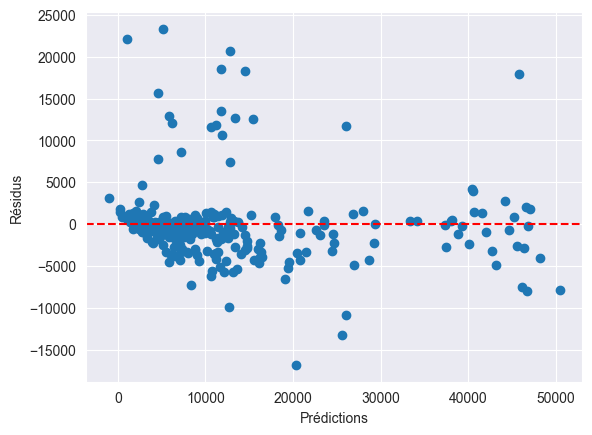

In [20]:
import matplotlib.pyplot as mpl
residus = y_test - y_pred
mpl.scatter(y_pred, residus)
mpl.axhline(0, color='red', linestyle='--')
mpl.xlabel("Prédictions")
mpl.ylabel("Résidus")
mpl.show()



feature story 4 2

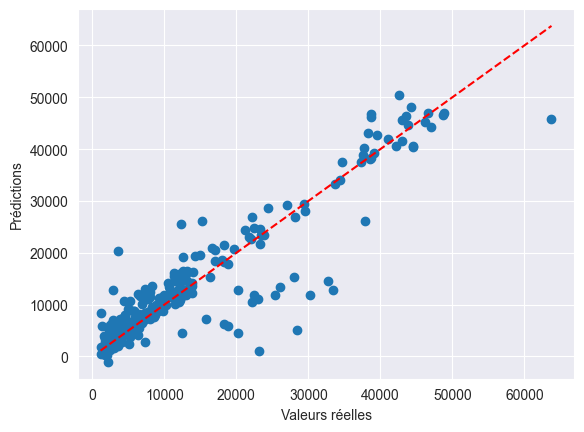

In [21]:
mpl.scatter(y_test, y_pred)
mpl.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ligne y=x
mpl.xlabel("Valeurs réelles")
mpl.ylabel("Prédictions")
mpl.show()
import matplotlib.pyplot as mpl

import pandas as pd

# Tag each row with the model name
xgbr_tagged = [{**d, "Model": "XGBRegressor"} for d in xgbr]
rndf_tagged = [{**d, "Model": "RandomForestRegressor"} for d in rndf]

df_scores = pd.DataFrame(xgbr_tagged + rndf_tagged)[["Model", "RMSE", "MAE", "R2"]]
print(df_scores)

In [33]:
import pandas as pd

df_scores = pd.DataFrame([
    {"Model": "XGBRegressor", "R2": xgbr[2]},
    {"Model": "randomforest", "R2": rndf[2]}

])

print(df_scores)

          Model        R2
0  XGBRegressor  0.882523
1  randomforest  0.869230


chose

In [36]:
from joblib import dump,load
dump(xgb_pipe, "best_IA")
loaded_model = load("best_IA")

#dump(scaler, "SmartSante_Scaler")
#scaler = load("SmartSante_Scaler")

In [48]:
# Simple console-style inputs and prediction using the already-loaded pipeline (loaded_model)
# No extra libraries for UI; just input() and print().
# Assumes pandas is already available from previous cells and loaded_model exists.

try:
    model = loaded_model  # reuse the loaded pipeline
except NameError:
    raise RuntimeError("Please ensure your trained pipeline is available as `loaded_model` in memory.")

# Basic helpers to read and validate
def read_int(prompt, min_v=None, max_v=None):
    while True:
        try:
            v = int(input(prompt).strip())
            if (min_v is not None and v < min_v) or (max_v is not None and v > max_v):
                print(f"Please enter an integer between {min_v} and {max_v}.")
                continue
            return v
        except ValueError:
            print("Please enter a valid integer.")

def read_float(prompt, min_v=None, max_v=None):
    while True:
        try:
            v = float(input(prompt).strip())
            if (min_v is not None and v < min_v) or (max_v is not None and v > max_v):
                print(f"Please enter a number between {min_v} and {max_v}.")
                continue
            return v
        except ValueError:
            print("Please enter a valid number.")

def read_choice(prompt, choices):
    choices_l = [c.lower() for c in choices]
    while True:
        v = input(f"{prompt} {choices}: ").strip().lower()
        if v in choices_l:
            return v
        print(f"Please choose one of {choices}.")

# Collect inputs
print("Enter your information:")
age = read_int("age (years): ", 18, 100)
bmi = read_float("bmi: ", 10, 80)
children = read_int("children (0-10): ", 0, 10)
sex = read_choice("sex", ["male", "female"])
smoker = read_choice("smoker", ["yes", "no"])
region = read_choice("region", ["southwest", "southeast", "northwest", "northeast"])

# Build a one-row DataFrame matching training columns
# Uses pandas that should already be imported earlier as pd
row = {
    "age": age,
    "bmi": bmi,
    "children": children,
    "sex": sex,
    "smoker": smoker,
    "region": region,
}

# Predict
# If your pipeline expects a pandas DataFrame with column names (typical with ColumnTransformer),
# ensure pd is available from earlier cells.
try:
    X_user = pd.DataFrame([row])
except NameError as e:
    raise RuntimeError("pandas (pd) must be available from earlier cells to build the input DataFrame.") from e

y_pred = model.predict(X_user)

print(f"\nEstimated charges: {float(y_pred[0]):,.2f}")

FileNotFoundError: [Errno 2] No such file or directory: 'models/best_xgb.joblib'